In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER


In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14, 24)
    
    # Create artificial aggregate
    t_subset[:, 0, :,:] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :,:] = t_subset[:, 0, :,:] + t_subset[:, i, :,:]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 14, 24)

In [6]:
t_all.shape

(52, 7, 14, 24)

In [7]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [8]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Conv1D, Dense, Flatten, MaxPool1D, InputLayer, Activation, Dropout, MaxPooling1D


import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.
/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [9]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

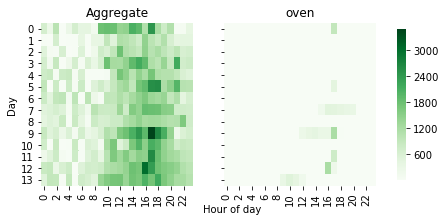

In [10]:
import seaborn as sns
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(6,3))
cbar_ax = fig.add_axes([.95, 0.15, .02, .7])
home = 4
appliance_num = 6
sns.heatmap(t_all[home, 0, :, :],cmap='Greens',ax=ax[0],cbar_ax=None,cbar=False)
sns.heatmap(t_all[home, appliance_num, :, :],cmap='Greens',ax=ax[1],cbar_ax=cbar_ax,vmax=t_all[home, 0, :, :].max())
ax[0].set_title("Aggregate")
ax[1].set_title(APPLIANCES_ORDER[appliance_num])
ax[0].set_ylabel("Day")
fig.text(0.5, 0, "Hour of day")


In [11]:
num_days = 14
num_hours = 24

In [12]:
maxs = {appliance_num:t_all[:30, appliance_num, :, :].max() for appliance_num in range(7)}

In [13]:
ENERGY_MEAN = {APPLIANCES_ORDER[i]:np.mean(t_all[:, i, :]) for i in list(range(1, 7))}
ENERGY_MEAN = pd.Series(ENERGY_MEAN)
ENERGY_MEAN.sort_values(inplace=True, ascending=False)
appliance_orders_subtract = [APPLIANCES_ORDER.index(x) for x in ENERGY_MEAN.index]

In [14]:
ENERGY_MEAN

hvac      894.701044
fridge     89.265252
oven       16.646041
dw         13.984549
mw          6.417846
wm          5.083840
dtype: float64

In [15]:

input_maxes = [t_all[:30, 0, :, :].max()]
for i in range(6):
    appliances_considered = appliance_orders_subtract[:i+1]
    input_maxes.append((t_all[:30, 0, :, :]-t_all[:30,appliances_considered , :, :].sum(axis=1)).max())
input_maxes

[5000.416633605957,
 3002.5000457763672,
 2914.800048828125,
 1126.2667155265808,
 960.7833251953125,
 498.43331909179688,
 0.0]

In [16]:
appliance_maxes = [t_all[:30, i, :, :].max() for i in appliance_orders_subtract]
appliance_maxes

[3963.88330078125,
 288.85000610351562,
 2914.800048828125,
 1122.300048828125,
 960.7833251953125,
 498.43331909179688]

In [17]:
t_all[:30, 0, :,:].max()

5000.416633605957

In [18]:
appliance_maxes

[3963.88330078125,
 288.85000610351562,
 2914.800048828125,
 1122.300048828125,
 960.7833251953125,
 498.43331909179688]

In [19]:
appliance_num=1
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Subtract, Merge
from keras.models import Model
from keras import backend as K

agg = Input(shape=(num_days, num_hours, 1),name='Aggregate')  # adapt this if using `channels_first` image data format
agg_norm = Lambda(lambda x: x/4000.,name='Norm')(agg)

hvac_c = Conv2D(6, (14, 1), activation='relu', padding='same',name='Conv-HVAC')(agg_norm)

hvac_d = Conv2D(1, (1,24), activation='relu', padding='same',name='HVAC')(hvac_c)

hvac_scaled = Lambda(lambda x: x*4000.)(hvac_d)
agg_minus_hvac = Subtract()([agg, hvac_scaled])

#agg_minus_hvac = Subtract()([agg, hvac_d])

agg_minus_hvac_norm = Lambda(lambda x: x/4000.,name='Norm-hvac')(agg_minus_hvac)
fridge_c = Conv2D(6, (14, 1), activation='relu', padding='same',name='Conv-Fridge')(agg_minus_hvac_norm)

fridge_d = Conv2D(1, (1,24), activation='relu', padding='same',name='Fridge')(fridge_c)

fridge_scaled = Lambda(lambda x: x*4000.)(fridge_d)
agg_minus_oven = Subtract()([agg_minus_hvac, fridge_scaled ])


agg_minus_oven_norm = Lambda(lambda x: x/4000.,name='Norm-hvac-oven')(agg_minus_oven)
oven_c = Conv2D(6, (14, 1), activation='relu', padding='same',name='Conv-Oven')(agg_minus_oven_norm)

oven_d = Conv2D(1, (1,24), activation='relu', padding='same',name='Oven')(oven_c)

oven_scaled = Lambda(lambda x: x*4000.)(oven_d)
agg_minus_dw = Subtract()([agg_minus_oven, oven_scaled ])


agg_minus_dw_norm = Lambda(lambda x: x/4000.,name='Norm-hvac-oven-dw')(agg_minus_dw)
dw_c = Conv2D(6, (14, 1), activation='relu', padding='same',name='Conv-dw')(agg_minus_dw_norm)

dw_d = Conv2D(1, (1,24), activation='relu', padding='same',name='DW')(dw_c)

#hvac_fridge = Merge(mode='concat',concat_axis=1)([hvac_d, fridge_d])

autoencoder = Model(agg, [hvac_d, fridge_d, oven_d, dw_d])
from keras.optimizers import Adam


In [20]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aggregate (InputLayer)          (None, 14, 24, 1)    0                                            
__________________________________________________________________________________________________
Norm (Lambda)                   (None, 14, 24, 1)    0           Aggregate[0][0]                  
__________________________________________________________________________________________________
Conv-HVAC (Conv2D)              (None, 14, 24, 6)    90          Norm[0][0]                       
__________________________________________________________________________________________________
HVAC (Conv2D)                   (None, 14, 24, 1)    145         Conv-HVAC[0][0]                  
__________________________________________________________________________________________________
lambda_1 (

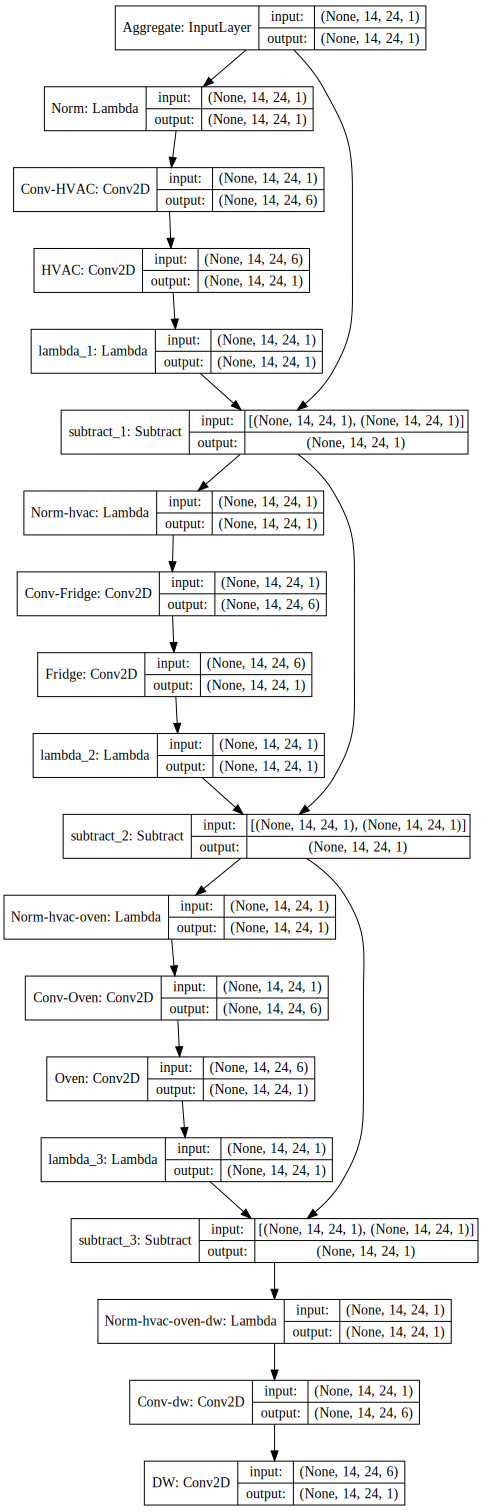

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(autoencoder,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [22]:
appliance_num=1
print(APPLIANCES_ORDER[appliance_num])

hvac


In [23]:
maxs, APPLIANCES_ORDER

({0: 5000.416633605957,
  1: 3963.88330078125,
  2: 288.85000610351562,
  3: 960.7833251953125,
  4: 1122.300048828125,
  5: 498.43331909179688,
  6: 2914.800048828125},
 ['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven'])

In [24]:
train_hvac = t_all[:30, 1, :, :].reshape(-1, num_days, num_hours,1) /4000.
train_fridge = t_all[:30, 2, :, :].reshape(-1, num_days, num_hours,1) /4000.
train_oven = t_all[:30, 6, :, :].reshape(-1, num_days, num_hours,1) /4000.
train_dw = t_all[:30, 4, :, :].reshape(-1, num_days, num_hours,1) /4000.

In [26]:
autoencoder.compile(optimizer='adam', loss='mean_absolute_error',loss_weights=[1, 18, 18,18])
for e in range(500):
    autoencoder.fit((t_all[:30, 0, :, :].reshape(-1, num_days, num_hours,1)),[train_hvac, train_fridge, train_oven, train_dw]
                ,validation_split=0.1,epochs=1,verbose=0)
    pred = autoencoder.predict(t_all[30:, 0, :, :].reshape(-1, num_days, num_hours,1))
    pred_hvac = 4000.*pred[0]
    pred_fridge = 4000.*pred[1]
    pred_oven = 4000.*pred[2]
    pred_dw = 4000.*pred[3]
    gt_hvac =t_all[30:, 1, :, :]
    gt_fridge =t_all[30:, 2, :, :]
    gt_oven =t_all[30:, 3, :, :]
    gt_dw =t_all[30:, 4, :, :]
    from sklearn.metrics import mean_absolute_error
    print(e, mean_absolute_error(gt_fridge.flatten(), pred_fridge.flatten()),
          mean_absolute_error(gt_hvac.flatten(), pred_hvac.flatten()),
         mean_absolute_error(gt_oven.flatten(), pred_oven.flatten()),
         mean_absolute_error(gt_dw.flatten(), pred_dw.flatten()))

0 33.46529688 125.692656222 6.3002141955 14.4991161736
1 33.0148366535 72.8441482975 6.3002141955 14.4991161736
2 32.8252944023 89.7934506007 6.3002141955 14.4991161736
3 32.8117162599 97.1607570471 6.3002141955 14.4991161736
4 32.8881643732 85.2619380215 6.3002141955 14.4991161736
5 33.03410384 73.0478036168 6.3002141955 14.4991161736
6 33.1978095698 81.9145613197 6.3002141955 14.4991161736
7 33.2593777495 90.4346546955 6.3002141955 14.4991161736
8 33.1987483651 81.7994707397 6.3002141955 14.4991161736
9 33.0760563819 72.8728634337 6.3002141955 14.4991161736
10 32.9685061303 75.6728858417 6.3002141955 14.4991161736
11 32.9085889859 79.9622196926 6.3002141955 14.4991161736
12 32.8970342524 79.0907905376 6.3002141955 14.4991161736
13 32.9247126244 74.5730876943 6.3002141955 14.4991161736
14 32.9850819106 72.709032698 6.3002141955 14.4991161736
15 33.0601998599 77.2492095145 6.3002141955 14.4991161736
16 33.1213591894 80.2919852302 6.3002141955 14.4991161736
17 33.1345214189 76.799840109

143 32.5576302995 72.787133889 6.3002141955 14.4991161736
144 32.3864749134 71.8507236457 6.3002141955 14.4991161736
145 32.3647905403 71.7736194663 6.3002141955 14.4991161736
146 32.6020511157 73.0385347244 6.3002141955 14.4991161736
147 32.2892537231 71.618427494 6.3002141955 14.4991161736
148 32.6100351124 73.1763051519 6.3002141955 14.4991161736
149 32.3355355557 71.7345238319 6.3002141955 14.4991161736
150 32.3820104924 71.9459025675 6.3002141955 14.4991161736
151 32.5055700453 72.6195345957 6.3002141955 14.4991161736
152 32.2836255259 71.6077017552 6.3002141955 14.4991161736
153 32.5301586116 72.786661986 6.3002141955 14.4991161736
154 32.3268607081 71.757928046 6.3002141955 14.4991161736
155 32.3723677913 71.9855681584 6.3002141955 14.4991161736
156 32.4291344061 72.3013489928 6.3002141955 14.4991161736
157 32.2990593962 71.7023277554 6.3002141955 14.4991161736
158 32.4989947514 72.6845439453 6.3002141955 14.4991161736
159 32.2613385441 71.6150898668 6.3002141955 14.4991161736
1

285 32.203093969 72.1893989324 6.3002141955 14.4991161736
286 32.4608831117 72.9897910178 6.3002141955 14.4991161736
287 32.2587932436 72.339012296 6.3002141955 14.4991161736
288 32.4044833096 72.7723788052 6.3002141955 14.4991161736
289 32.2674012747 72.3402996996 6.3002141955 14.4991161736
290 32.412631408 72.7218347055 6.3002141955 14.4991161736
291 32.2483375073 72.2847642086 6.3002141955 14.4991161736
292 32.4740143979 72.8754015998 6.3002141955 14.4991161736
293 32.2077096211 72.2535974929 6.3002141955 14.4991161736
294 32.5500785598 73.1839416449 6.3002141955 14.4991161736
295 32.206430861 72.2853826583 6.3002141955 14.4991161736
296 32.5438776264 73.2220419917 6.3002141955 14.4991161736
297 32.2108262747 72.2877962753 6.3002141955 14.4991161736
298 32.5283083261 73.1597086771 6.3002141955 14.4991161736
299 32.2185713043 72.2883328782 6.3002141955 14.4991161736
300 32.4993728338 73.0195801312 6.3002141955 14.4991161736
301 32.2309849743 72.3060624641 6.3002141955 14.4991161736
3

427 32.4608434909 72.6297194613 6.3002141955 14.4991161736
428 32.2335093935 72.1624651799 6.3002141955 14.4991161736
429 32.6101014408 72.9762217116 6.3002141955 14.4991161736
430 32.1847045804 72.1504467655 6.3002141955 14.4991161736
431 32.6762418654 73.1682907515 6.3002141955 14.4991161736
432 32.1977505684 72.1825102742 6.3002141955 14.4991161736
433 32.5621103511 72.8947844603 6.3002141955 14.4991161736
434 32.2726299164 72.2614351449 6.3002141955 14.4991161736
435 32.4313544335 72.5560929618 6.3002141955 14.4991161736
436 32.3144637272 72.3028050851 6.3002141955 14.4991161736
437 32.4385950875 72.5369773825 6.3002141955 14.4991161736
438 32.2550442653 72.1603103366 6.3002141955 14.4991161736
439 32.5440967432 72.7892086821 6.3002141955 14.4991161736
440 32.1908322547 72.1073232811 6.3002141955 14.4991161736
441 32.6760734632 73.1655979745 6.3002141955 14.4991161736
442 32.1825240407 72.1518625065 6.3002141955 14.4991161736
443 32.624196507 73.0621347837 6.3002141955 14.499116173

In [26]:
pred = autoencoder.predict(t_all[30:, 0, :, :].reshape(-1, num_days, num_hours,1))

In [27]:
pred_hvac = maxs[1]*pred[0]
pred_fridge = maxs[2]*pred[1]

gt_hvac =t_all[30:, 1, :, :]
gt_fridge =t_all[30:, 2, :, :]

#pred_hvac = 1.*autoencoder.predict(t_all[30:, 0, :, :].reshape(-1, num_days, num_hours,1))[:, :14,:, :]
#pred_fridge = 1.*autoencoder.predict(t_all[30:, 0, :, :].reshape(-1, num_days, num_hours,1))[:, 14:28,:, :]

gt_hvac =t_all[30:, 1, :, :]
gt_fridge =t_all[30:, 2, :, :]










In [28]:
pred = maxs[appliance_num]*autoencoder.predict(t_all[30:, 0, :, :].reshape(-1, num_days, num_hours,1)).reshape(-1, num_days, num_hours)
gt =t_all[30:, appliance_num, :, :]


pred_fl = pred.flatten()
gt_fl = gt.flatten()

AttributeError: 'list' object has no attribute 'reshape'

In [29]:
pred.shape, (t_all[:30, 0, :, :].reshape(-1, num_days, num_hours,1)/maxs[0]).shape

AttributeError: 'list' object has no attribute 'shape'

In [29]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(gt_fridge.flatten(), pred_fridge.flatten())
mean_absolute_error(gt_hvac.flatten(), pred_hvac.flatten())

72.00008459583789

In [30]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [31]:
pred_overall_appliance = (1.*autoencoder.predict(t_all[30:, 0, :, :].reshape(-1, num_days, num_hours,1))).reshape(-1,14,24)
ax = pd.DataFrame(pred_overall_appliance[1, 3, :]).squeeze().plot(label='Predicted HVAC')
pd.DataFrame(gt[1, 3, :]).squeeze().plot(ax=ax,label="GT HVAC")
#pd.DataFrame(t_all[31,4, 3, :]).squeeze().plot(ax=ax,label="GT DW")
plt.legend()
plt.savefig("/Users/nipun/Desktop/hvac-cnn.png")

TypeError: can't multiply sequence by non-int of type 'float'

In [34]:
gt_hvac.shape

(22, 14, 24)

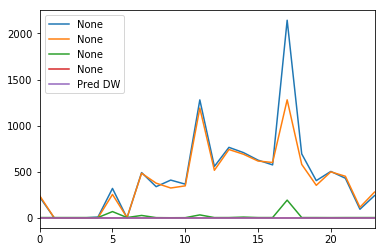

In [63]:
pd.Series(pred_hvac[0, 1,:,:].flatten()).plot()
pd.Series(gt_hvac[0,1,:].flatten()).plot()
pd.Series(gt_oven[0,1,:].flatten()).plot()
pd.Series(pred_oven[0,1,:].flatten()).plot()
pd.Series(pred_dw[0,1,:].flatten()).plot(label='Pred DW')
plt.legend()

In [65]:
pred_oven.sum()

0.0

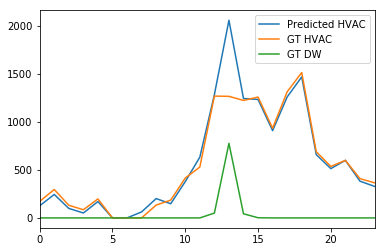

In [45]:
pred_overall_appliance = (maxs[appliance_num]*autoencoder.predict(t_all[30:, 0, :, :].reshape(-1, num_days, num_hours,1))).reshape(-1,14,24)
ax = pd.DataFrame(pred_overall_appliance[1, 3, :]).squeeze().plot(label='Predicted HVAC')
pd.DataFrame(gt[1, 3, :]).squeeze().plot(ax=ax,label="GT HVAC")
pd.DataFrame(t_all[31,4, 3, :]).squeeze().plot(ax=ax,label="GT DW")
plt.legend()
plt.savefig("/Users/nipun/Desktop/hvac-dw-cnn.png")

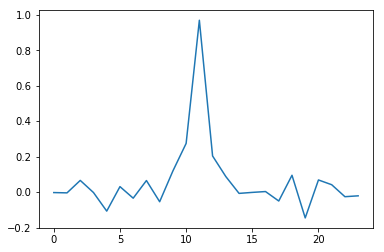

In [266]:
plt.plot(autoencoder.layers[2].get_weights()[0].flatten())

In [10]:
train_agg = t_all[:30, 0, :].reshape(30*14, 24)
train_appliance = {}
test_appliance = {}
for appliance_num, appliance in enumerate(APPLIANCES_ORDER[1:]):
    train_appliance[appliance] = t_all[:30, appliance_num+1, :].reshape(30*14, 24)
    test_appliance[appliance] = t_all[30:, appliance_num+1, :].reshape(22*14, 24)






test_hvac = t_all[30:, 1, :].reshape(22*14, 24)
test_fridge = t_all[30:, 2, :].reshape(22*14, 24)

test_mw = t_all[30:, 3, :].reshape(22*14, 24)



test_agg = t_all[30:, 0, :].reshape(22*14, 24)

In [11]:
train_hvac.shape

NameError: name 'train_hvac' is not defined

In [12]:
train_hvac_fridge = np.hstack([train_hvac, train_fridge])
test_hvac_fridge = np.hstack([test_hvac, test_fridge])

NameError: name 'train_hvac' is not defined

In [80]:
#pred_appliance = {}
sequence_length=24
num_iterations_dictionary = {'hvac':400,'fridge':500,'mw':250,'dw':250,'oven':250, 'wm':300}
for appliance in APPLIANCES_ORDER[2:]:


    print(appliance)
    print("*"*20)
    np.random.seed(0)
    from keras.layers.merge import Subtract, Minimum
    model = Sequential()
    filters=20
    kernel_size=2
    model.add(InputLayer(input_shape=(sequence_length,1)))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='same',
                     activation='relu',
                     strides=1 ,name='C1'))
    model.add(MaxPooling1D(pool_size=2))


    model.add(Dropout(rate=0.1))
    model.add(Conv1D(filters=20,
                     kernel_size=5,
                     padding='same',
                     activation='relu',
                     strides=1 ))
    model.add(MaxPooling1D(pool_size=2))



    model.add(Dropout(rate=0.1))

    model.add(Conv1D(filters=25,
                     kernel_size=3,
                     padding='same',
                     activation='relu',
                     strides=1 ))
    model.add(MaxPooling1D(pool_size=2))


    model.add(Dropout(rate=0.1))

    model.add(Conv1D(filters=30,
                     kernel_size=2,
                     padding='same',
                     activation='relu',
                     strides=1 ))
    model.add(MaxPooling1D(pool_size=2))



    model.add(Dropout(rate=0.1))

    model.add(Flatten())
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(sequence_length, activation='relu'))
    model.add(Dropout(rate=0.1))


    model.compile('adam','mean_absolute_error')
    model.fit(train_agg.reshape(-1, 24, 1), train_appliance[appliance], epochs=num_iterations_dictionary[appliance], validation_split=0.1)
    pred_appliance[appliance] = model.predict(test_agg.reshape(-1,24,1))



fridge
********************
Train on 378 samples, validate on 42 samples
Epoch 1/500
378/378 [==============================] - 1s 3ms/step - loss: 104.0335 - val_loss: 80.1024
Epoch 2/500
378/378 [==============================] - 0s 128us/step - loss: 73.5439 - val_loss: 82.9650
Epoch 3/500
378/378 [==============================] - 0s 120us/step - loss: 69.5276 - val_loss: 71.1884
Epoch 4/500
378/378 [==============================] - 0s 124us/step - loss: 65.7872 - val_loss: 66.9487
Epoch 5/500
378/378 [==============================] - 0s 123us/step - loss: 61.5952 - val_loss: 60.5597
Epoch 6/500
378/378 [==============================] - 0s 121us/step - loss: 57.9371 - val_loss: 58.2805
Epoch 7/500
378/378 [==============================] - 0s 123us/step - loss: 54.5536 - val_loss: 53.5956
Epoch 8/500
378/378 [==============================] - 0s 116us/step - loss: 52.0083 - val_loss: 48.1487
Epoch 9/500
378/378 [==============================] - 0s 110us/step - loss: 49.8050 - v

Epoch 154/500
378/378 [==============================] - 0s 112us/step - loss: 36.6051 - val_loss: 40.9227
Epoch 155/500
378/378 [==============================] - 0s 114us/step - loss: 36.8613 - val_loss: 37.9792
Epoch 156/500
378/378 [==============================] - 0s 118us/step - loss: 36.0987 - val_loss: 39.7679
Epoch 157/500
378/378 [==============================] - 0s 114us/step - loss: 35.8294 - val_loss: 40.1168
Epoch 158/500
378/378 [==============================] - 0s 112us/step - loss: 35.9135 - val_loss: 40.3052
Epoch 159/500
378/378 [==============================] - 0s 113us/step - loss: 35.9357 - val_loss: 41.5186
Epoch 160/500
378/378 [==============================] - 0s 116us/step - loss: 36.4006 - val_loss: 42.6061
Epoch 161/500
378/378 [==============================] - 0s 112us/step - loss: 36.0867 - val_loss: 39.4884
Epoch 162/500
378/378 [==============================] - 0s 120us/step - loss: 36.2109 - val_loss: 40.9371
Epoch 163/500
378/378 [==============

378/378 [==============================] - 0s 112us/step - loss: 31.1762 - val_loss: 39.1932
Epoch 307/500
378/378 [==============================] - 0s 124us/step - loss: 31.3601 - val_loss: 40.4758
Epoch 308/500
378/378 [==============================] - 0s 116us/step - loss: 30.9723 - val_loss: 39.7988
Epoch 309/500
378/378 [==============================] - 0s 115us/step - loss: 31.2240 - val_loss: 39.2697
Epoch 310/500
378/378 [==============================] - 0s 115us/step - loss: 31.3497 - val_loss: 39.5279
Epoch 311/500
378/378 [==============================] - 0s 122us/step - loss: 31.1582 - val_loss: 39.6884
Epoch 312/500
378/378 [==============================] - 0s 117us/step - loss: 31.5861 - val_loss: 40.0486
Epoch 313/500
378/378 [==============================] - 0s 113us/step - loss: 31.2570 - val_loss: 38.6425
Epoch 314/500
378/378 [==============================] - 0s 114us/step - loss: 31.3038 - val_loss: 40.4669
Epoch 315/500
378/378 [============================

378/378 [==============================] - 0s 117us/step - loss: 30.3796 - val_loss: 40.3136
Epoch 459/500
378/378 [==============================] - 0s 113us/step - loss: 30.4188 - val_loss: 39.4738
Epoch 460/500
378/378 [==============================] - 0s 134us/step - loss: 30.3670 - val_loss: 41.0653
Epoch 461/500
378/378 [==============================] - 0s 139us/step - loss: 31.0115 - val_loss: 40.8251
Epoch 462/500
378/378 [==============================] - 0s 148us/step - loss: 29.9184 - val_loss: 39.8697
Epoch 463/500
378/378 [==============================] - 0s 142us/step - loss: 30.1677 - val_loss: 40.4435
Epoch 464/500
378/378 [==============================] - 0s 109us/step - loss: 30.2846 - val_loss: 39.8982
Epoch 465/500
378/378 [==============================] - 0s 118us/step - loss: 30.1463 - val_loss: 40.1937
Epoch 466/500
378/378 [==============================] - 0s 122us/step - loss: 30.7215 - val_loss: 39.5725
Epoch 467/500
378/378 [============================

378/378 [==============================] - 0s 121us/step - loss: 6.3622 - val_loss: 8.3305
Epoch 36/250
378/378 [==============================] - 0s 114us/step - loss: 6.3444 - val_loss: 8.3305
Epoch 37/250
378/378 [==============================] - 0s 118us/step - loss: 6.3139 - val_loss: 8.3305
Epoch 38/250
378/378 [==============================] - 0s 116us/step - loss: 6.3362 - val_loss: 8.3305
Epoch 39/250
378/378 [==============================] - 0s 125us/step - loss: 6.3247 - val_loss: 8.3305
Epoch 40/250
378/378 [==============================] - 0s 116us/step - loss: 6.3242 - val_loss: 8.3305
Epoch 41/250
378/378 [==============================] - 0s 118us/step - loss: 6.3202 - val_loss: 8.3305
Epoch 42/250
378/378 [==============================] - 0s 117us/step - loss: 6.3161 - val_loss: 8.3305
Epoch 43/250
378/378 [==============================] - 0s 116us/step - loss: 6.3093 - val_loss: 8.3305
Epoch 44/250
378/378 [==============================] - 0s 121us/step - loss:

Epoch 114/250
378/378 [==============================] - 0s 117us/step - loss: 6.3000 - val_loss: 8.3305
Epoch 115/250
378/378 [==============================] - 0s 111us/step - loss: 6.3026 - val_loss: 8.3305
Epoch 116/250
378/378 [==============================] - 0s 113us/step - loss: 6.3038 - val_loss: 8.3305
Epoch 117/250
378/378 [==============================] - 0s 119us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 118/250
378/378 [==============================] - 0s 123us/step - loss: 6.3026 - val_loss: 8.3305
Epoch 119/250
378/378 [==============================] - 0s 121us/step - loss: 6.3047 - val_loss: 8.3305
Epoch 120/250
378/378 [==============================] - 0s 114us/step - loss: 6.3041 - val_loss: 8.3305
Epoch 121/250
378/378 [==============================] - 0s 114us/step - loss: 6.3017 - val_loss: 8.3305
Epoch 122/250
378/378 [==============================] - 0s 113us/step - loss: 6.3045 - val_loss: 8.3305
Epoch 123/250
378/378 [==============================] 

378/378 [==============================] - 0s 129us/step - loss: 6.3026 - val_loss: 8.3305
Epoch 193/250
378/378 [==============================] - 0s 115us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 194/250
378/378 [==============================] - 0s 115us/step - loss: 6.3023 - val_loss: 8.3305
Epoch 195/250
378/378 [==============================] - 0s 116us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 196/250
378/378 [==============================] - 0s 115us/step - loss: 6.2995 - val_loss: 8.3305
Epoch 197/250
378/378 [==============================] - 0s 117us/step - loss: 6.3016 - val_loss: 8.3305
Epoch 198/250
378/378 [==============================] - 0s 125us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 199/250
378/378 [==============================] - 0s 119us/step - loss: 6.3012 - val_loss: 8.3305
Epoch 200/250
378/378 [==============================] - 0s 116us/step - loss: 6.3010 - val_loss: 8.3305
Epoch 201/250
378/378 [==============================] - 0s 124us/ste

378/378 [==============================] - 0s 126us/step - loss: 13.4612 - val_loss: 15.0648
Epoch 97/250
378/378 [==============================] - 0s 118us/step - loss: 13.4559 - val_loss: 15.0648
Epoch 98/250
378/378 [==============================] - 0s 129us/step - loss: 13.4462 - val_loss: 15.0648
Epoch 99/250
378/378 [==============================] - 0s 121us/step - loss: 13.4459 - val_loss: 15.0648
Epoch 100/250
378/378 [==============================] - 0s 124us/step - loss: 13.4473 - val_loss: 15.0648
Epoch 101/250
378/378 [==============================] - 0s 125us/step - loss: 13.4471 - val_loss: 15.0648
Epoch 102/250
378/378 [==============================] - 0s 124us/step - loss: 13.4526 - val_loss: 15.0648
Epoch 103/250
378/378 [==============================] - 0s 124us/step - loss: 13.4521 - val_loss: 15.0648
Epoch 104/250
378/378 [==============================] - 0s 129us/step - loss: 13.4508 - val_loss: 15.0648
Epoch 105/250
378/378 [==============================]

378/378 [==============================] - 0s 128us/step - loss: 13.4452 - val_loss: 15.0648
Epoch 249/250
378/378 [==============================] - 0s 120us/step - loss: 13.4452 - val_loss: 15.0648
Epoch 250/250
378/378 [==============================] - 0s 113us/step - loss: 13.4452 - val_loss: 15.0648
wm
********************
Train on 378 samples, validate on 42 samples
Epoch 1/300
378/378 [==============================] - 1s 3ms/step - loss: 83.1399 - val_loss: 17.0875
Epoch 2/300
378/378 [==============================] - 0s 129us/step - loss: 15.5730 - val_loss: 5.7701
Epoch 3/300
378/378 [==============================] - 0s 125us/step - loss: 7.4662 - val_loss: 4.5463
Epoch 4/300
378/378 [==============================] - 0s 128us/step - loss: 6.1663 - val_loss: 4.3702
Epoch 5/300
378/378 [==============================] - 0s 128us/step - loss: 5.5833 - val_loss: 4.3453
Epoch 6/300
378/378 [==============================] - 0s 124us/step - loss: 5.3496 - val_loss: 4.3410
Epoch

378/378 [==============================] - 0s 119us/step - loss: 4.7265 - val_loss: 4.3410
Epoch 155/300
378/378 [==============================] - 0s 127us/step - loss: 4.7330 - val_loss: 4.3410
Epoch 156/300
378/378 [==============================] - 0s 117us/step - loss: 4.7379 - val_loss: 4.3410
Epoch 157/300
378/378 [==============================] - 0s 130us/step - loss: 4.7319 - val_loss: 4.3410
Epoch 158/300
378/378 [==============================] - 0s 128us/step - loss: 4.7332 - val_loss: 4.3410
Epoch 159/300
378/378 [==============================] - 0s 136us/step - loss: 4.7318 - val_loss: 4.3410
Epoch 160/300
378/378 [==============================] - 0s 129us/step - loss: 4.7411 - val_loss: 4.3410
Epoch 161/300
378/378 [==============================] - 0s 122us/step - loss: 4.7391 - val_loss: 4.3410
Epoch 162/300
378/378 [==============================] - 0s 119us/step - loss: 4.7347 - val_loss: 4.3410
Epoch 163/300
378/378 [==============================] - 0s 126us/ste

378/378 [==============================] - 0s 134us/step - loss: 14.6388 - val_loss: 13.5292
Epoch 10/250
378/378 [==============================] - 0s 125us/step - loss: 14.5970 - val_loss: 13.5281
Epoch 11/250
378/378 [==============================] - 0s 134us/step - loss: 14.5895 - val_loss: 13.5295
Epoch 12/250
378/378 [==============================] - 0s 124us/step - loss: 14.5554 - val_loss: 13.5289
Epoch 13/250
378/378 [==============================] - 0s 133us/step - loss: 14.5966 - val_loss: 13.5239
Epoch 14/250
378/378 [==============================] - 0s 135us/step - loss: 14.5681 - val_loss: 13.5176
Epoch 15/250
378/378 [==============================] - 0s 133us/step - loss: 14.5617 - val_loss: 13.5187
Epoch 16/250
378/378 [==============================] - 0s 124us/step - loss: 14.5268 - val_loss: 13.5165
Epoch 17/250
378/378 [==============================] - 0s 123us/step - loss: 14.5224 - val_loss: 13.5165
Epoch 18/250
378/378 [==============================] - 0s 

Epoch 86/250
378/378 [==============================] - 0s 121us/step - loss: 14.4617 - val_loss: 13.5180
Epoch 87/250
378/378 [==============================] - 0s 134us/step - loss: 14.4544 - val_loss: 13.5179
Epoch 88/250
378/378 [==============================] - 0s 122us/step - loss: 14.4448 - val_loss: 13.5183
Epoch 89/250
378/378 [==============================] - 0s 129us/step - loss: 14.4630 - val_loss: 13.5165
Epoch 90/250
378/378 [==============================] - 0s 132us/step - loss: 14.4542 - val_loss: 13.5165
Epoch 91/250
378/378 [==============================] - 0s 131us/step - loss: 14.4567 - val_loss: 13.5181
Epoch 92/250
378/378 [==============================] - 0s 134us/step - loss: 14.4473 - val_loss: 13.5075
Epoch 93/250
378/378 [==============================] - 0s 121us/step - loss: 14.4660 - val_loss: 13.5007
Epoch 94/250
378/378 [==============================] - 0s 132us/step - loss: 14.4361 - val_loss: 13.5165
Epoch 95/250
378/378 [========================

378/378 [==============================] - 0s 131us/step - loss: 12.7644 - val_loss: 12.3515
Epoch 239/250
378/378 [==============================] - 0s 133us/step - loss: 12.8034 - val_loss: 12.4435
Epoch 240/250
378/378 [==============================] - 0s 119us/step - loss: 12.6870 - val_loss: 12.4177
Epoch 241/250
378/378 [==============================] - 0s 128us/step - loss: 12.7014 - val_loss: 12.5220
Epoch 242/250
378/378 [==============================] - 0s 132us/step - loss: 12.6575 - val_loss: 12.5753
Epoch 243/250
378/378 [==============================] - 0s 122us/step - loss: 12.7996 - val_loss: 12.5444
Epoch 244/250
378/378 [==============================] - ETA: 0s - loss: 10.83 - 0s 128us/step - loss: 12.7116 - val_loss: 12.3564
Epoch 245/250
378/378 [==============================] - 0s 137us/step - loss: 12.6985 - val_loss: 12.5121
Epoch 246/250
378/378 [==============================] - 0s 130us/step - loss: 12.6630 - val_loss: 12.5820
Epoch 247/250
378/378 [====

In [25]:
with open('per-appliance.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))

